#California Housing Price Prediction

**Problem**:To predict the selling price of a house in California based on the following features:
1. longitude: A measure of how far west a house is; a higher value is farther west
2. latitude: A measure of how far north a house is; a higher value is farther north
3. housingMedianAge: Median age of a house within a block; a lower number is a newer building
4. totalRooms: Total number of rooms within a block
5. totalBedrooms: Total number of bedrooms within a block
6. population: Total number of people residing within a block
7. households: Total number of households, a group of people residing within a home unit, for a block
8. medianIncome: Median income for households within a block of houses (measured in tens of thousands of US Dollars)
9. medianHouseValue: Median house value for households within a block (measured in US Dollars)
10. oceanProximity: Location of the house w.r.t ocean/sea

The dataset is obtained from Kaggle : https://www.kaggle.com/camnugent/california-housing-prices

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [1]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [3]:
import seaborn as sns
from sklearn.linear_model import SGDRegressor,Lasso,ElasticNet,Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

In [4]:
df=pd.read_csv("housing.csv")

##Visualizing our data ready

We need to know more about our data so that we can manipulate it to give best possible results.

In [5]:
#checking whether we received the data
df.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [8]:
df["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

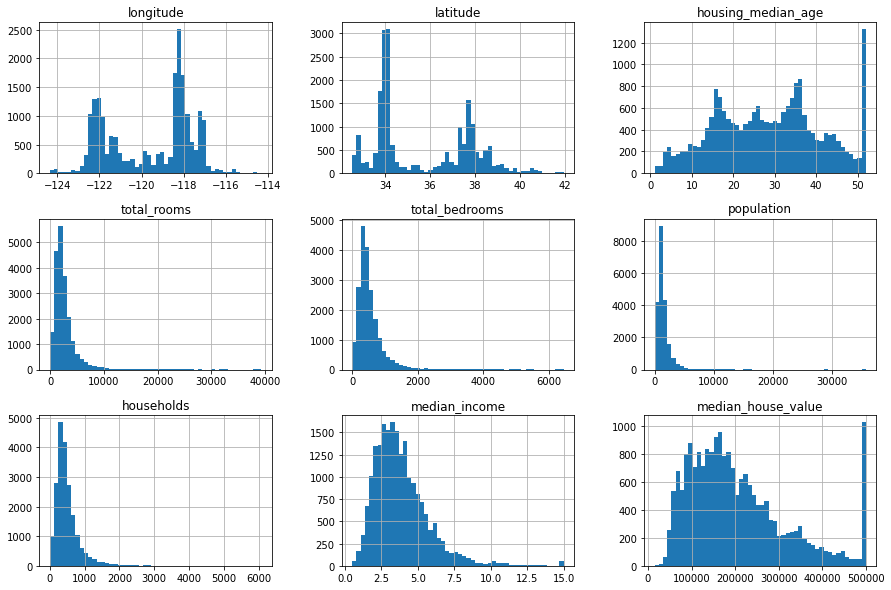

In [9]:
#histograms are the best way to visualize data
df.hist(bins=50,figsize=(15,10));

Let's take a look where all these houses lie.

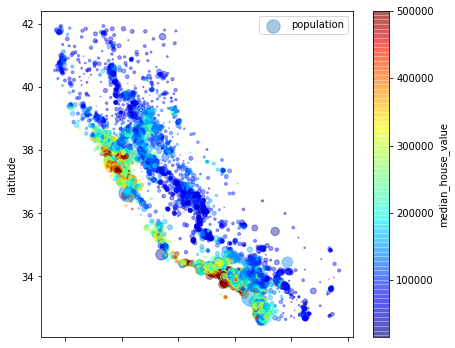

In [10]:
df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=df["population"]/100, label="population",
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True, 
              figsize=(7,6))
plt.legend();

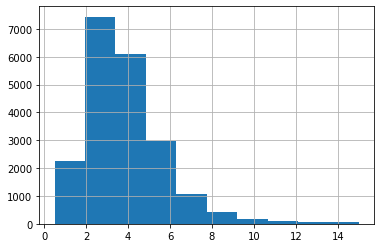

In [ ]:
df["median_income"].hist()

From the histogram we can infer that most of income of people lies between the values 2 and 5.

##Splitting data and filling missing values

Let's split the data into training and test set based on the income of people so as not to loose the ratio.

In [11]:
df["income"]=np.ceil(df["median_income"]/1.5)
df["income"].where(df["income"]<5.0,5.0,inplace=True)

In [12]:
#Spitting the dataset into training and test
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["income"]):
      df_train = df.loc[train_index]
      df_test = df.loc[test_index] 

In [13]:
df_train.drop("income",axis=1,inplace=True)
df_test.drop("income",axis=1,inplace=True)

In [14]:
df_train.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        158
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [15]:
df_test.isna().sum()

longitude              0
latitude               0
housing_median_age     0
total_rooms            0
total_bedrooms        49
population             0
households             0
median_income          0
median_house_value     0
ocean_proximity        0
dtype: int64

In [16]:
df_train.fillna(df_train["total_bedrooms"].median(),inplace=True)
df_test.fillna(df_test["total_bedrooms"].median(),inplace=True)

Let's play around with data to get more features for that we are creating a copy of the training data.

In [17]:
data=df_train.copy()

##Feature Extraction

Removing unneeded columns and adding new columns to our data.

In [ ]:
data.head(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN


In [18]:
corr_mat=data.corr()

In [19]:
corr_mat["median_income"].sort_values(ascending=False)

median_income         1.000000
median_house_value    0.687160
total_rooms           0.200087
households            0.010781
population            0.002380
total_bedrooms       -0.009512
longitude            -0.019583
latitude             -0.075205
housing_median_age   -0.111360
Name: median_income, dtype: float64

In [20]:
data["pop_per_household"]=data["population"]/data["households"]
data["rooms_per_household"]=data["total_rooms"]/data["total_bedrooms"]
data["bed_per_room"]=data["total_bedrooms"]/data["total_rooms"]

In [21]:
corr_mat=data.corr()
corr_mat["median_income"].sort_values(ascending=False)

median_income          1.000000
rooms_per_household    0.728907
median_house_value     0.687160
total_rooms            0.200087
pop_per_household      0.021822
households             0.010781
population             0.002380
total_bedrooms        -0.009512
longitude             -0.019583
latitude              -0.075205
housing_median_age    -0.111360
bed_per_room          -0.544525
Name: median_income, dtype: float64

In [22]:
df_test["pop_per_household"]=df_test["population"]/df_test["households"]
df_test["rooms_per_household"]=df_test["total_rooms"]/df_test["total_bedrooms"]
df_test["bed_per_room"]=df_test["total_bedrooms"]/df_test["total_rooms"]

In [23]:
data.drop("population",axis=1,inplace=True)
df_test.drop("population",axis=1,inplace=True)

data.drop("total_bedrooms",axis=1,inplace=True)
df_test.drop("total_bedrooms",axis=1,inplace=True)

data.drop("households",axis=1,inplace=True)
df_test.drop("households",axis=1,inplace=True)

##Getting our data ready

In [24]:
x_train=data.drop("median_house_value",axis=1)
y_train=data["median_house_value"]

In [25]:
x_test=df_test.drop("median_house_value",axis=1)
y_test=df_test["median_house_value"]

In [27]:
cat={"<1H OCEAN":3,"INLAND":5,"ISLAND":0,"NEAR BAY":8,"NEAR OCEAN":2}
x_train["ocean_proximity"]=x_train["ocean_proximity"].map(cat)
x_test["ocean_proximity"]=x_test["ocean_proximity"].map(cat)

##Selecting model

Choosing appropriate model that suits our data.

In [ ]:
model={"sgd": SGDRegressor(),
       "las": Lasso(),
       "elas":ElasticNet(),
       "rid":Ridge(),
       "svr":SVR(),
       "rand":RandomForestRegressor()
       }


def fitscore(model,x_train,y_train,x_test,y_test):
  np.random.seed(42)
  for name,models in model.items():
    models.fit(x_train,y_train)
    print(f"{name} {models.score(x_test,y_test)}")

In [ ]:
fitscore(model,x_train,y_train,x_test,y_test)

sgd -3.2958352107191534e+21
las 0.613109230821623
elas 0.5695014560588767
rid 0.6130461338858922
svr -0.05407812604564954
rand 0.8213922271084937


##Hyperparameter Tuning

We are choosing random forest regressor for our problem and now hypertuning its parameters to get better results.

In [ ]:
rand=RandomForestRegressor()
rand.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
rand_reg={"n_estimators":[5,50,100],
          "max_depth":[None,3,6,9,10],
          "min_samples_split":np.arange(2,6,2),
          "min_samples_leaf":[1,3,6,8],
          }

In [ ]:
np.random.seed(42)
rand = GridSearchCV(estimator=RandomForestRegressor(),
                    param_grid=rand_reg,
                    cv=5,          
                    verbose=2)

In [ ]:
#warning do not run this cell it takes 37 minutes
rand.fit(x_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [ ]:
rand.best_params_

{'max_depth': None,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 100}

In [ ]:
rand.best_score_

0.809988834297901

In [ ]:
rand_reg={"n_estimators":[100,150,200],
          "max_depth":[None,3,6,9,10],
          "min_samples_split":np.arange(2,6,2),
          "min_samples_leaf":[1,3,6,8]
          }

In [ ]:
np.random.seed(42)
rand = GridSearchCV(estimator=RandomForestRegressor(),
                    param_grid=rand_reg,
                    cv=5,          
                    verbose=2)

In [ ]:
#warning this cell takes 76 minutes
rand.fit(x_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [ ]:
rand.best_params_

{'max_depth': None,
 'min_samples_leaf': 3,
 'min_samples_split': 4,
 'n_estimators': 200}

In [ ]:
rand.best_score_

0.810784423862468

In [ ]:
rand_reg={"n_estimators":np.arange(190,210,2),
          "max_depth":[None],
          "min_samples_split":np.arange(2,6,2),
          "min_samples_leaf":[1,3,6,8]
          }

In [ ]:
np.random.seed(42)
rand = GridSearchCV(estimator=RandomForestRegressor(),
                    param_grid=rand_reg,
                    cv=5,          
                    verbose=2)

In [ ]:
#warning this cell takes 104 minutes
rand.fit(x_train,y_train)

[CV]  max_depth=None, min_samples_leaf=8, min_samples_split=4, n_estimators=208, total=  14.3s
[CV] max_depth=None, min_samples_leaf=8, min_samples_split=4, n_estimators=208 
[CV]  max_depth=None, min_samples_leaf=8, min_samples_split=4, n_estimators=208, total=  14.3s
[CV] max_depth=None, min_samples_leaf=8, min_samples_split=4, n_estimators=208 
[CV]  max_depth=None, min_samples_leaf=8, min_samples_split=4, n_estimators=208, total=  14.5s


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed: 104.8min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [ ]:
rand.best_score_

0.8114606664638021

In [ ]:
rand.best_params_

{'max_depth': None,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 206}

#Putting it all together

In [ ]:
def dataeng(df):
  df["income"]=np.ceil(df["median_income"]/1.5)
  df["income"].where(df["income"]<5.0,5.0,inplace=True)

  split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
  for train_index, test_index in split.split(df, df["income"]):
      df_train = df.loc[train_index]
      df_test = df.loc[test_index] 
      
  df_train.drop("income",axis=1,inplace=True)
  df_test.drop("income",axis=1,inplace=True)

  df_train.fillna(df_train["total_bedrooms"].median(),inplace=True)
  df_test.fillna(df_test["total_bedrooms"].median(),inplace=True)

  df_train["pop_per_household"]=df_train["population"]/df_train["households"]
  df_train["rooms_per_household"]=df_train["total_rooms"]/df_train["total_bedrooms"]
  df_train["bed_per_room"]=df_train["total_bedrooms"]/df_train["total_rooms"]

  df_test["pop_per_household"]=df_test["population"]/df_test["households"]
  df_test["rooms_per_household"]=df_test["total_rooms"]/df_test["total_bedrooms"]
  df_test["bed_per_room"]=df_test["total_bedrooms"]/df_test["total_rooms"]

  df_train.drop("population",axis=1,inplace=True)
  df_test.drop("population",axis=1,inplace=True)
  df_train.drop("total_bedrooms",axis=1,inplace=True)
  df_test.drop("total_bedrooms",axis=1,inplace=True)
  df_train.drop("households",axis=1,inplace=True)
  df_test.drop("households",axis=1,inplace=True)

  x=df_train.drop("median_house_value",axis=1)
  y=df_train["median_house_value"]

  x1=df_test.drop("median_house_value",axis=1)
  y1=df_test["median_house_value"]

  cat={"<1H OCEAN":3,"INLAND":5,"ISLAND":0,"NEAR BAY":8,"NEAR OCEAN":2}
  x["ocean_proximity"]=x["ocean_proximity"].map(cat)
  x1["ocean_proximity"]=x1["ocean_proximity"].map(cat)

  return x,y,x1,y1

In [ ]:
data=df.copy()
x_train,y_train,x_test,y_test=dataeng(data)

In [ ]:
np.random.seed(42)
rf=RandomForestRegressor(n_estimators=206,min_samples_split=2,min_samples_leaf=3)

In [ ]:
rf.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=206, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
rf.score(x_test,y_test)

0.8222810384253783